# Handling Outliers and Basic Exploratory Analysis

A note about shortcuts and code syntax: While I have worked hard to make this script accessible to everyone, there are a few things that you can do to make working with this script more powerful for yourself

-If you are working inside of a cell, and wish to come out of that cell, press the `Esc` key

-Pressing `m` while a cell is selected (but not active), will convert that cell's output into 'Markdown' (i.e., the language used to display this text). Pressing `y` will convert it back to code

-Highlighting code and pressing `Crtl` + `/` will comment out/in the code. Python uses `#` to denote comments, which also tells the interpreter to ignore that particular line of code. A few cells in this script give you the opportunity to look at the data. Using the keyboard shortcut above, you can make that line of code and active. You can also simply delete the `#` in front of the code

-If you wish to insert a cell, click outside of the cell above/below the location where you wish to place your cell. Press `a` to insert your cell above that cell, and `b` to place your cell below the current cell. If you wish to delete a cell, click outside of the cell you wish to delete, and click the cut (scissors) icon in the toolbar

-Python allows for strings to be entered as either `''` or `""`, but whatever you choose, it must be consistent. If you need to add a string somewhere, keep this in mind

-`ods.shape` prints out (displays) the number of columns and rows; `ods.info()` prints out an info summary about null-values, number of rows and columns, dtypes, column names, etc...(generally the most useful when looking for a high-level overview); `ods.columns` prints out the column names; `ods.head(x)\ods.tail(x)` will print out the *x* number of rows from the top/bottom (*note that x>50 will still generally result in data being cut off when printed to screen*)

### ***Functions***

In [275]:
import pandas as pd
import numpy as np
import plotly.express as px

In [276]:
# Formats the date for multiple columns
def fmt_dt(df, *cols):
        for col in cols:
            df[col] = pd.to_datetime(df[col].dt.strftime('%Y-%m-%d %H:%M:%S'))

def col_range(col, df):
    return df[col].max - df[col].min

**Load in the dataframe**

*If you wish to add a csv file, use 'Indicators_remvoed_and_basic_analysis'. You should only be loading in one file at this point*

In [277]:
file = input('Enter the name of the file without the extension: ')
finals_file = input('Enter the name of the finals semester without the extension: ')

Enter the name of the file without the extension: 
Enter the name of the finals semester without the extension: 


In [278]:
ods = pd.read_pickle(f'{file}.pkl')
odsFinals = pd.read_pickle(f'{finals_file}.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '.pkl'

**Add another column that displays the day of the week**

In [279]:
ods.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9482 entries, 0 to 11238
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   subject                              9482 non-null   object        
 1   section                              9482 non-null   int64         
 2   exam_date                            9482 non-null   datetime64[ns]
 3   proctor                              9482 non-null   object        
 4   room_number                          9482 non-null   string        
 5   start_time                           9482 non-null   object        
 6   end_time                             9482 non-null   object        
 7   actual_start                         9482 non-null   object        
 8   actual_end                           9482 non-null   object        
 9   first_entered                        9482 non-null   datetime64[ns]
 10  fileUploade

In [280]:
ods.columns

Index(['subject', 'section', 'exam_date', 'proctor', 'room_number',
       'start_time', 'end_time', 'actual_start', 'actual_end', 'first_entered',
       'fileUploaded', 'received_as_paper_copy', 'rescheduled',
       'breaks_during_exams', 'extra_time_1.50x', 'extra_time_2.00x',
       'makeup_accommodation', 'noScantronExam', 'readerForExams',
       'allotted_time', 'actual_time', 'exam_cancelled', 'no_show',
       'days_requested_submitted_in_advance', 'name_of_day'],
      dtype='object')

In [281]:
ods['name_of_day'] = ods['exam_date'].dt.day_name()
odsFinals['name_of_day'] = odsFinals['exam_date'].dt.day_name()

## *Basic Summary Statistics and Outliers for Regular Semester Exams*

<AxesSubplot:>

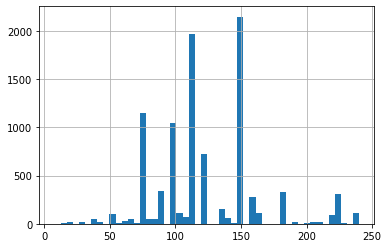

In [282]:
ods['allotted_time'].hist(bins=50)

*One obvious outlier we can get rid of is for 'allotted_time'. No student would have gotten over 3 and a half days to take an exam*

In [283]:
ods.loc[ods['allotted_time'] == 5070, ['subject', 'allotted_time', 'exam_date']]

,subject,allotted_time,exam_date


*What is the average amount of time these students got?*

In [284]:
ods.loc[(ods['subject'] == 'ENGR'), 'allotted_time'].mean()

117.32

*300 minutes is a common amount of time give on final exams, but we can see none of these dates align with final exam scheduling. We will drop these values*

In [285]:
drop = ods[ods['allotted_time']==5070].index
ods.drop(index=drop, inplace=True)

***Note: We have left GBA finals in the regular semester dataframe. This is because GBA Finals are typically taken a few weeks before finals begins, and thus, impacts normal testing operations***

count    9482.000000
mean      124.250475
std        39.889051
min         8.000000
25%       100.000000
50%       113.000000
75%       150.000000
max       240.000000
Name: allotted_time, dtype: float64


count    6673.000000
mean       75.764274
std        38.273212
min         0.000000
25%        46.000000
50%        73.000000
75%       100.000000
max       240.000000
Name: actual_time, dtype: float64


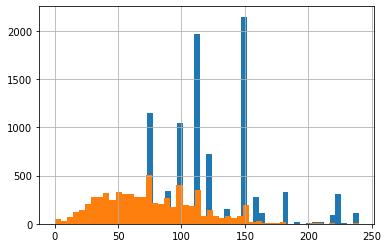

In [286]:
ods['allotted_time'].hist(bins=50)
ods['actual_time'].hist(bins=50)
print(ods['allotted_time'].describe())
print('\n')
print(ods['actual_time'].describe())

**Print out a 'box-and-whisker' plot**

<AxesSubplot:>

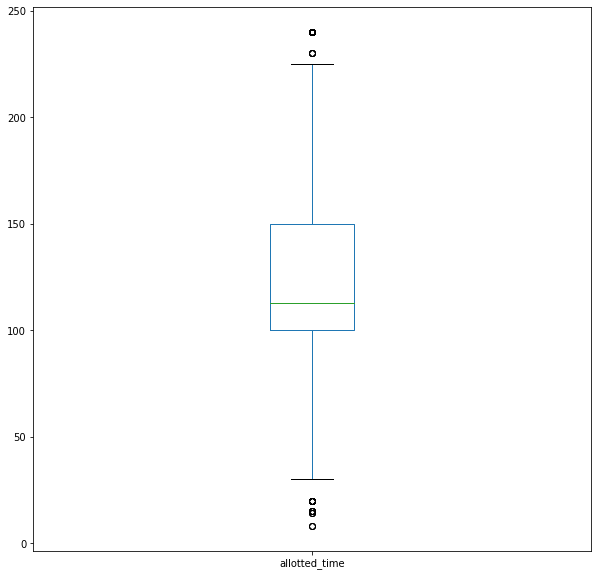

In [287]:
ods['allotted_time'].plot(kind='box', figsize=(10,10))

<AxesSubplot:>

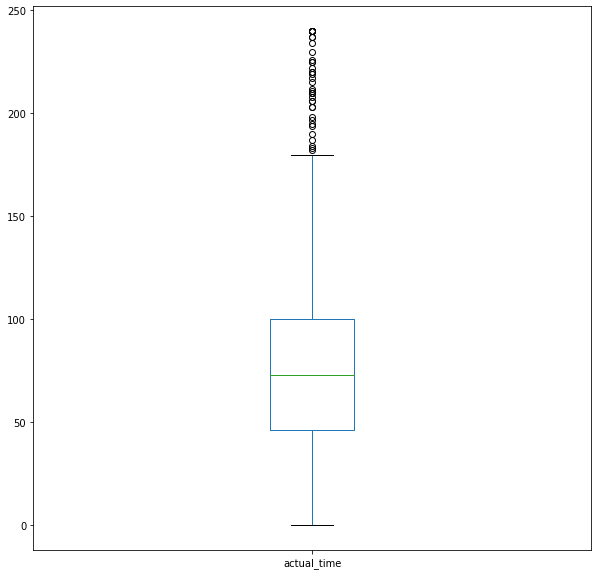

In [288]:
ods['actual_time'].plot(kind='box', figsize=(10,10))

**Set the threshhold for 'allotted_time' to be 240, except for exams that are GBA finals, which are taken a week/two weeks before normal final exams**

In [289]:
ods.loc[ods['allotted_time'] > 240, ['subject', 'allotted_time', 'actual_time', 'exam_date', 'exam_cancelled', 'no_show']]

,subject,allotted_time,actual_time,exam_date,exam_cancelled,no_show


In [290]:
thresh=240
ods.drop(index = ods[(ods['allotted_time']>thresh) & (ods['subject']!= 'GBA')].index, inplace=True)

**Handle the lower bound of outliers**

In [291]:
ods.loc[ods['allotted_time']< 30, ['allotted_time', 'actual_time', 'subject', 'section','no_show', 'exam_cancelled', 'exam_date',
                                   'extra_time_1.50x']]


ods.drop(index=ods[(ods['allotted_time'] == 0.0) & (ods['actual_time'].isna())].index, inplace=True)

**Impute Missing Data**

In [292]:
# # Fill in the missing allotted time from other exams in the same subject and on the same day
# ods.loc[(ods['exam_date'] == '2019-11-07') & (ods['subject'] == 'EC'), ['allotted_time', 'actual_time', 'extra_time_1.50x']]
# ods.loc[(ods['exam_date'] == '2020-02-03') & (ods['subject'] == 'PY'), ['allotted_time', 'actual_time', 'extra_time_1.50x']]
# ods.loc[(ods['exam_date'] == '2020-02-03') & (ods['subject'] == 'FI'), ['allotted_time', 'actual_time', 'extra_time_1.50x']]
# ods.loc[(ods['exam_date'] == '2020-03-03') & (ods['subject'] == 'BSC'), ['allotted_time', 'actual_time', 'extra_time_1.50x',
#                                                                          'section']]


*The student receives 1.50 extra time. Other exams on that date and in that subject (with 1.50x) received 113 mins*

**Drop rows that have no values to reference**

In [293]:
# ods.drop(index=7237,inplace=True)

**Fill in the missing allotted time for EC with 113**

In [294]:
ods.loc[3279, ['allotted_time']]=113.0
ods.loc[4172, ['allotted_time']]=360.0
ods.loc[7229, ['allotted_time']]=75.0
ods.loc[8854, ['allotted_time']]=120.0

In [295]:
ods.loc[ods['allotted_time']< 30, ['allotted_time', 'actual_time', 'subject', 'section','no_show', 'exam_cancelled', 'exam_date',
                                   'extra_time_1.50x']]

,allotted_time,actual_time,subject,section,no_show,exam_cancelled,exam_date,extra_time_1.50x
1265,20.0,NaN,HY,28.0,True,False,2019-10-01,No
1376,15.0,15.0,HY,28.0,False,False,2019-10-02,Yes
1632,20.0,NaN,CD,1.0,False,True,2019-10-08,No
2044,20.0,NaN,CD,1.0,False,True,2019-10-15,No
2354,15.0,15.0,HY,28.0,False,False,2019-10-21,Yes
2414,20.0,20.0,HY,28.0,False,False,2019-10-22,No
3275,20.0,20.0,CD,1.0,False,False,2019-11-07,No
3365,15.0,15.0,HY,28.0,False,False,2019-11-08,Yes
4155,15.0,NaN,HY,28.0,True,False,2019-11-22,Yes
4296,20.0,NaN,CD,1.0,True,False,2019-11-26,No


## Handle Actual Time Outliers

In [296]:
# ods.loc[ods['actual_time'] > 194, ['subject', 'section', 'allotted_time', 'actual_time', 'exam_date']]

***First, as per discussion with ODS Director, actual_times that went over allotted_times will be set to the allotted_time. We also need to update the ending time***

In [297]:
idx = ods.loc[ods['actual_time'] > ods['allotted_time']].index
ods.loc[idx, ['actual_end']] = ods['end_time']
ods.loc[idx, ['actual_time']] = ods['allotted_time']

In [298]:
ods.loc[ods['actual_time'] > 194, ['subject', 'section', 'allotted_time', 'actual_time', 'exam_date', 'start_time']]

,subject,section,allotted_time,actual_time,exam_date,start_time
613,AEM,4.0,240.0,215.0,2019-09-19,16:30:00
734,CE,1.0,240.0,234.0,2019-09-23,15:00:00
1382,CHE,1.0,240.0,230.0,2019-10-02,17:00:00
1523,MIS,1.0,220.0,212.0,2019-10-04,13:00:00
1625,CTD,2.0,220.0,210.0,2019-10-08,12:50:00
1743,CS,910.0,240.0,240.0,2019-10-09,14:00:00
1971,CE,1.0,240.0,240.0,2019-10-14,15:00:00
2291,AEM,4.0,240.0,211.0,2019-10-17,18:00:00
2292,AEM,4.0,240.0,240.0,2019-10-17,18:00:00
3389,CE,1.0,240.0,240.0,2019-11-11,15:05:00


**These are incorrect. Replace with the correct times (Verified through ODS Portal)**

In [299]:
ods.loc[1048, ['actual_time']]=150
ods.loc[1048, ['allotted_time']]=150

*Let's move GBA finals to the final frame. It may be skewing our data too much*

In [300]:
gba_finals = ods[(ods['allotted_time']==360.0)|(ods['allotted_time']==480.0)|
                 (ods['allotted_time']==225.0) & (ods['subject']=='GBA') & 
                 (ods['exam_date']=='07-31-2019')]
odsFinals = pd.concat([odsFinals, gba_finals])
idx = ods[(ods['allotted_time']==360.0)|(ods['allotted_time']==480.0)|
                 (ods['allotted_time']==225.0) & (ods['subject']=='GBA') & 
                 (ods['exam_date']=='07-31-2019')].index
ods.drop(index=idx, inplace=True)

## Isolate Night Time and Day Time Testing Stats

## *Basic Summary Statistics and Outliers for Final Exams*

In [301]:
num_cols = ods.select_dtypes(include='number')
num_cols = num_cols.drop(columns=['section', 'rescheduled'])


## Vizs

In [302]:
px.box(data_frame=num_cols)

In [303]:
ods.to_csv('ods_export_to_postgres.csv')
odsFinals.to_csv('odsFinals_export_to_postgres.csv')

## Correlations

In [304]:
ods.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9482 entries, 0 to 11238
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   subject                              9482 non-null   object        
 1   section                              9482 non-null   float64       
 2   exam_date                            9482 non-null   datetime64[ns]
 3   proctor                              9482 non-null   object        
 4   room_number                          9482 non-null   string        
 5   start_time                           9482 non-null   object        
 6   end_time                             9482 non-null   object        
 7   actual_start                         9482 non-null   object        
 8   actual_end                           9482 non-null   object        
 9   first_entered                        9482 non-null   datetime64[ns]
 10  fileUploade

In [327]:
def actual_t_percent(x):
    return ods[x].sum() / ods['allotted_time'].sum()

actual_t_percent('actual_time')

0.4291287220651483

In [338]:
ods.groupby(by=['subject']).agg({'allotted_time': ['sum'], 'actual_time': ['sum', 'mean']})
                                                                                                        

allotted_time actual_time            
                  sum         sum        mean
subject                                      
AAST            226.0       226.0  113.000000
AC            70892.0     35603.0   95.195187
AEM           38361.0     19351.0  105.168478
AMS            2992.0      1705.0   71.041667
ANT             901.0       193.0   48.250000
...               ...         ...         ...
SW              180.0       146.0  146.000000
TEST            300.0         1.0    1.000000
TH             2438.0      1073.0   51.095238
UH             1283.0       653.0  108.833333
WS              413.0       273.0   91.000000

[73 rows x 3 columns]